#**Response to Marketing Campaign**

##**Assignment**

You are working as a Data Scientist. A task has been commissioned by an insurance company to develop a tool to optimize their marketing efforts. They have given us a data set as a result of an email marketing campaign. The data set includes customer information, described below, as a well as whether the customer responded to the marketing campaign or not.

Design a model that will be able to predict whether a customer will respond to the marketing campaign based on his/her information. In other words, predict the responded target variable described above based on all the input variables provided.

**Briefly answer the following questions:**

1. Describe your model and why did you choose this model over other types of models?
2. Describe any other models you have tried and why do you think this model preforms better?
3. How did you handle missing data?
4. How did you handle categorical (string) data?
5. How did you handle unbalanced data?
6. How did you test your model?

Data Description
Files:

marketing_training.csv - contains the training set that you will use to build the model. The target variable is responded.
marketing_test.csv – contains testing data where the input variables are provided but not the responded target column.

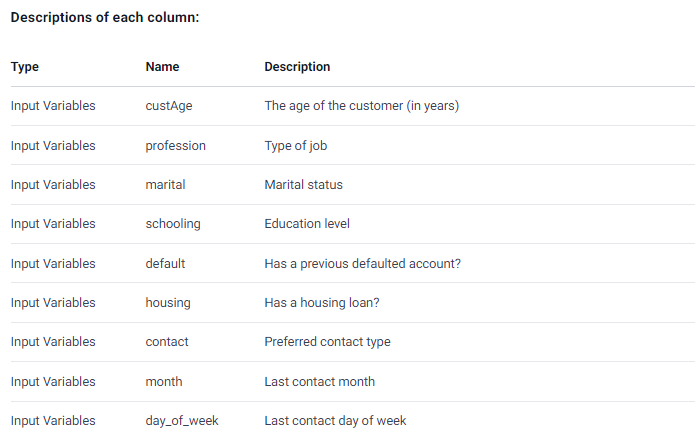
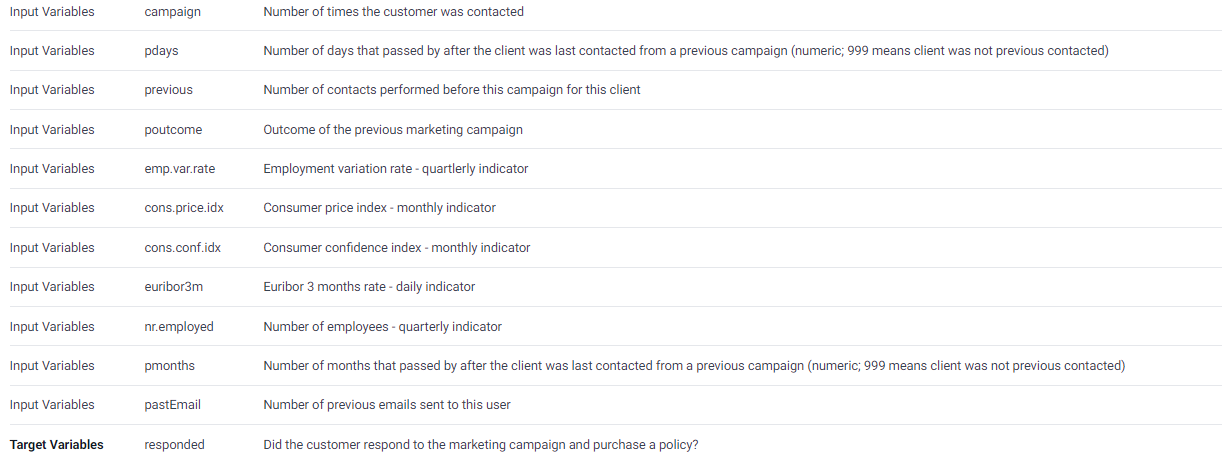

###**Practicalities**

**Provide the following:**

- The source code you used to build the model and make predictions. (You are free to use any language and any open-source package/library)
- A .csv file containing the predictions of the test data. You can add the target column (responded) to the test data or simply provide it alone with the id column.


#### To download the dataset <a href="https://drive.google.com/drive/folders/1WNZVfcDqD1LJakOuKF0STWwALjRxwjlw?usp=sharing"> Click here </a>

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the datasets
train_path = r"C:\Users\manoj\Downloads\marketing_training.csv"
test_path = r"C:\Users\manoj\Downloads\marketing_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [117]:
# Data Overview
print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("\nTraining Data Info:")
print(train_data.info())

# Check for Missing Values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

# Statistical Summary
print("\nStatistical Summary of Training Data:")
print(train_data.describe())

# Target Variable Distribution
print("\nTarget Variable Distribution (responded):")
print(train_data['responded'].value_counts(normalize=True))


Training Data Shape: (7414, 22)
Test Data Shape: (824, 22)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7414 entries, 0 to 7413
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   custAge         5610 non-null   float64
 1   profession      7414 non-null   object 
 2   marital         7414 non-null   object 
 3   schooling       5259 non-null   object 
 4   default         7414 non-null   object 
 5   housing         7414 non-null   object 
 6   loan            7414 non-null   object 
 7   contact         7414 non-null   object 
 8   month           7414 non-null   object 
 9   day_of_week     6703 non-null   object 
 10  campaign        7414 non-null   int64  
 11  pdays           7414 non-null   int64  
 12  previous        7414 non-null   int64  
 13  poutcome        7414 non-null   object 
 14  emp.var.rate    7414 non-null   float64
 15  cons.price.idx  7414 non-null   float64
 16

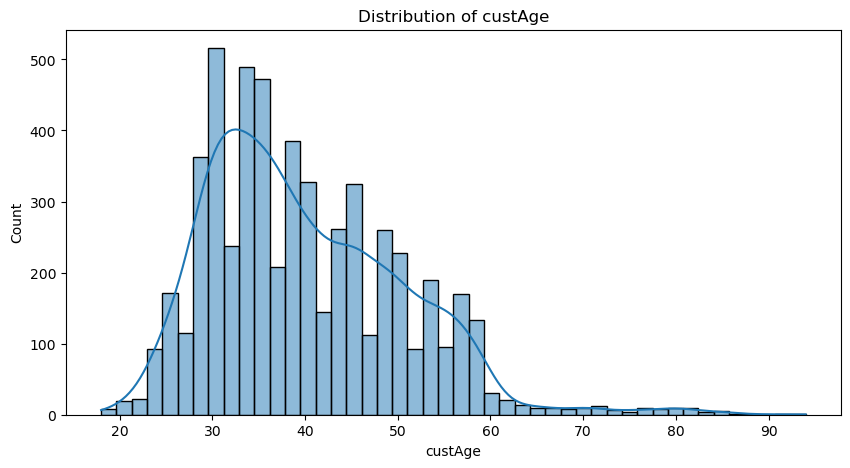

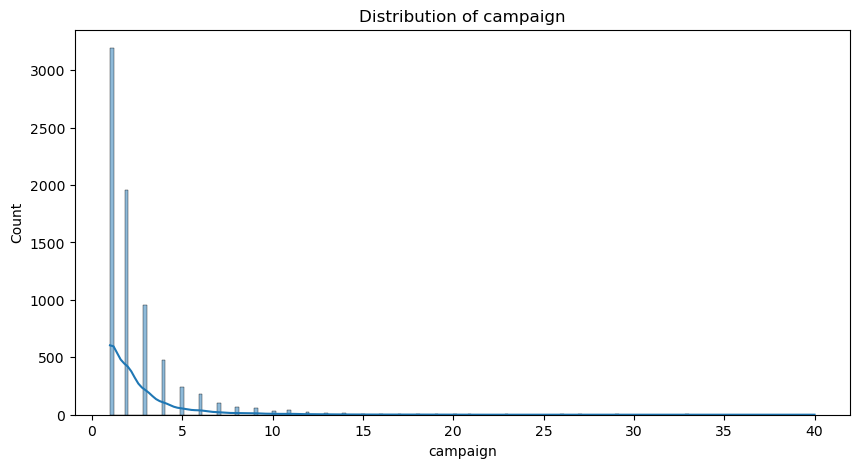

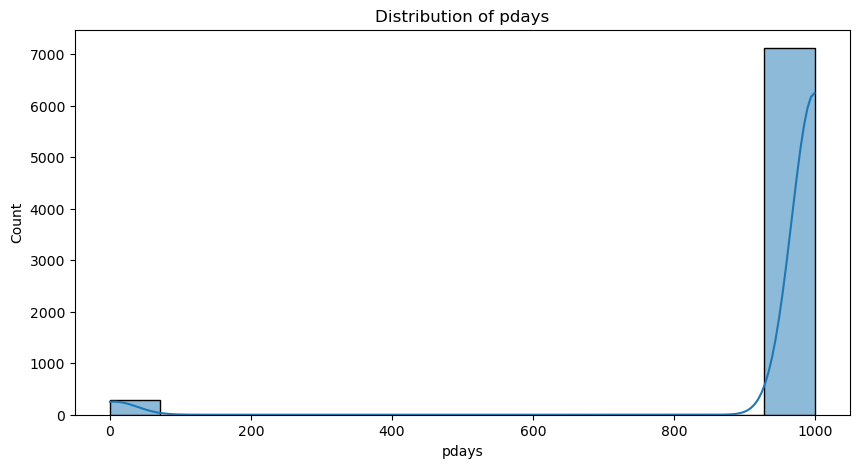

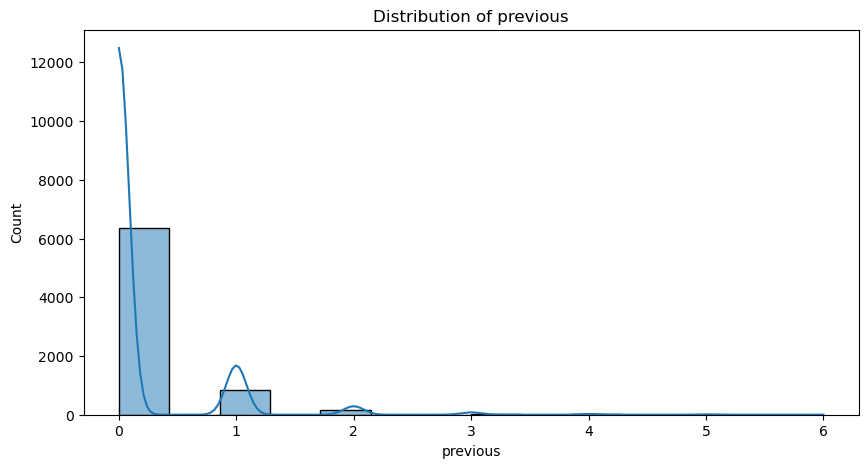

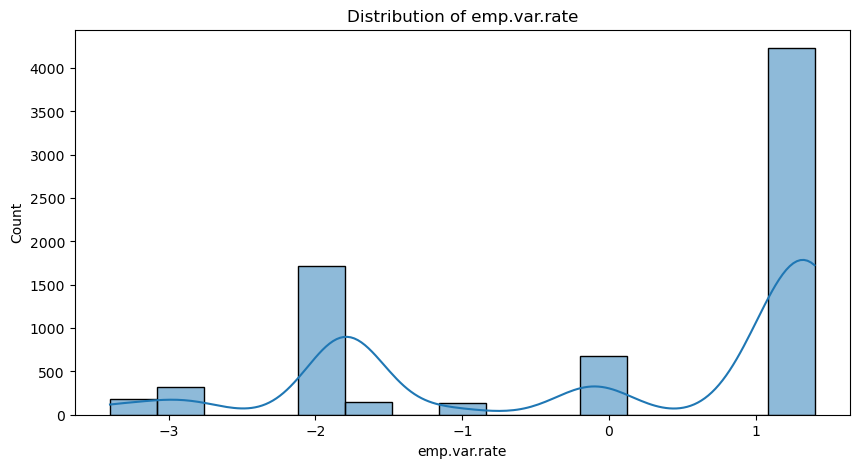

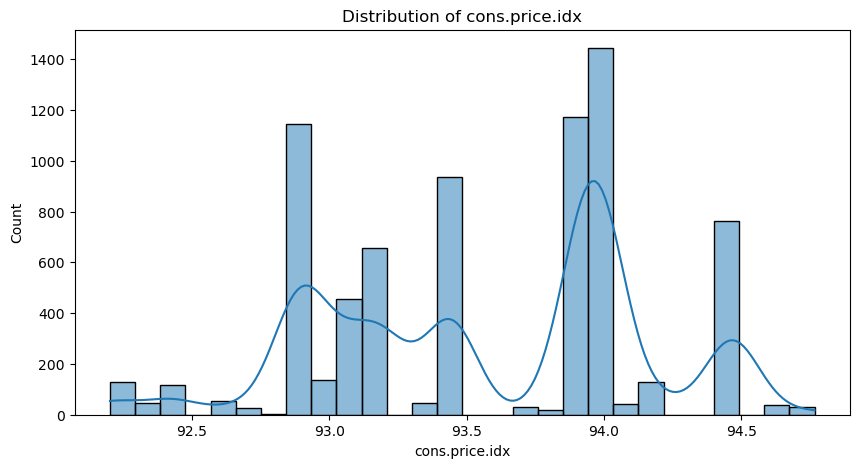

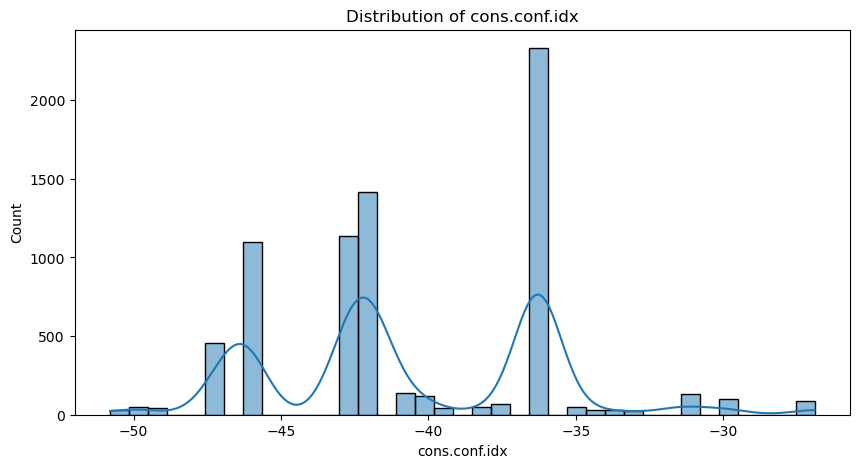

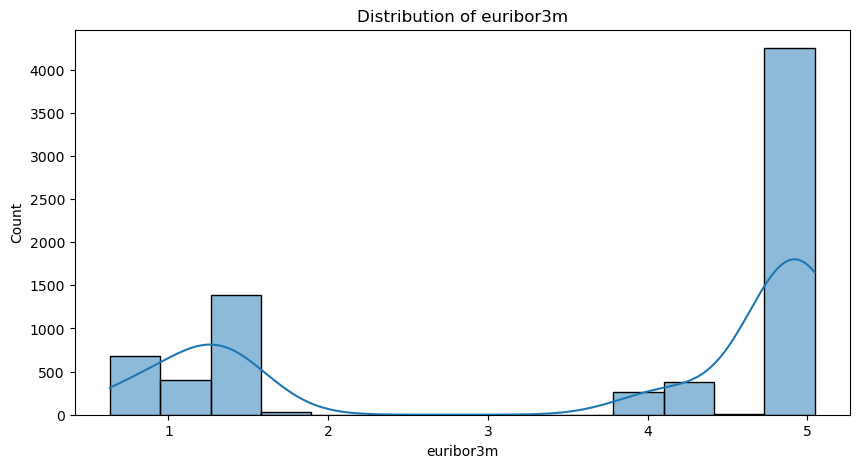

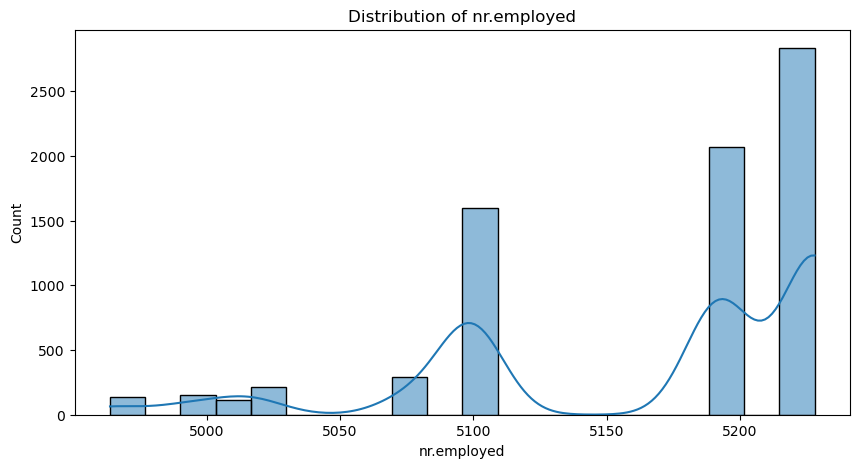

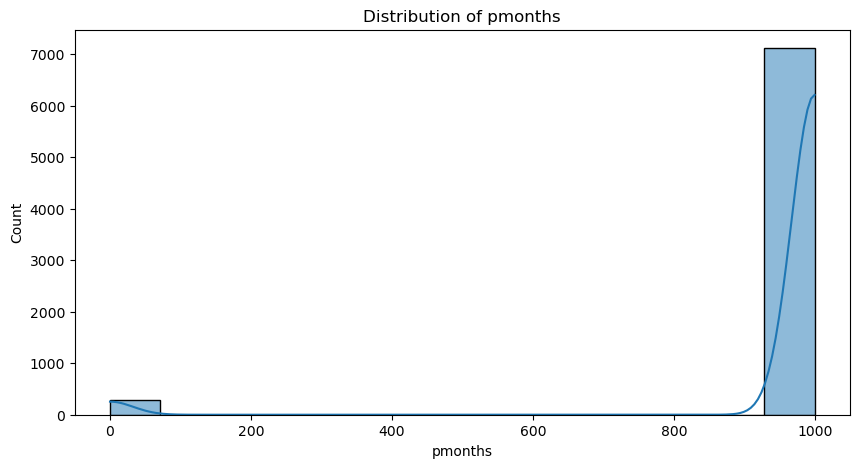

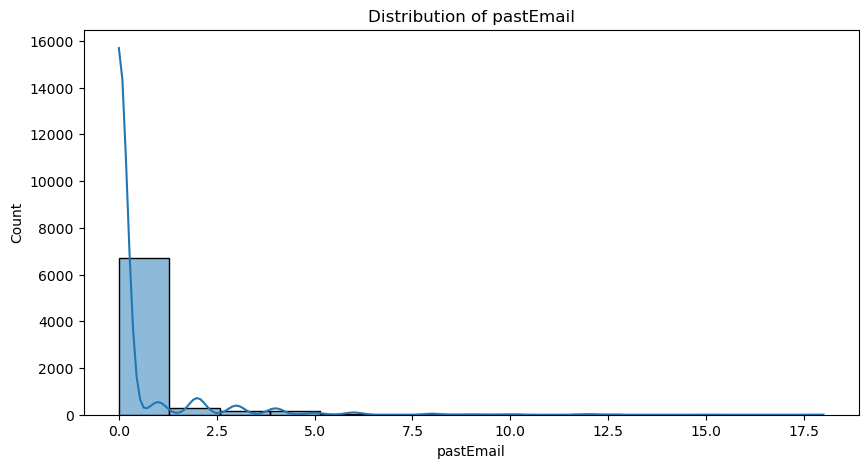

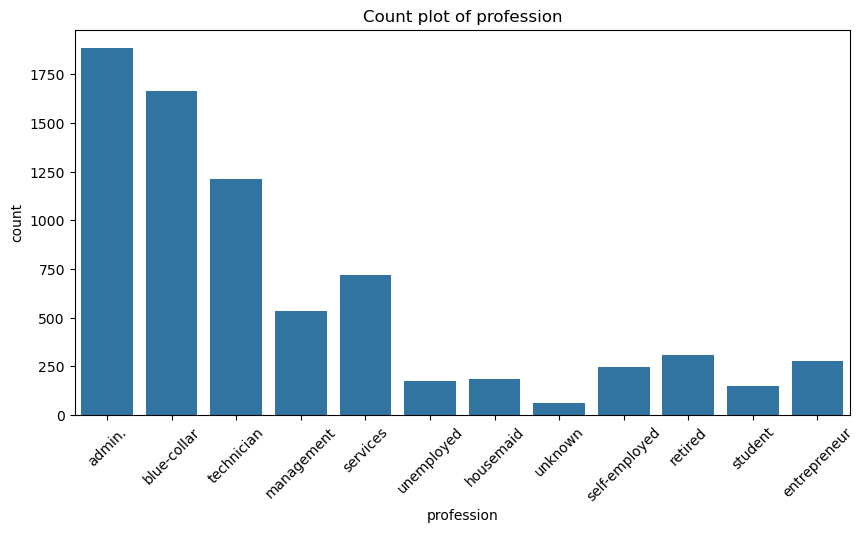

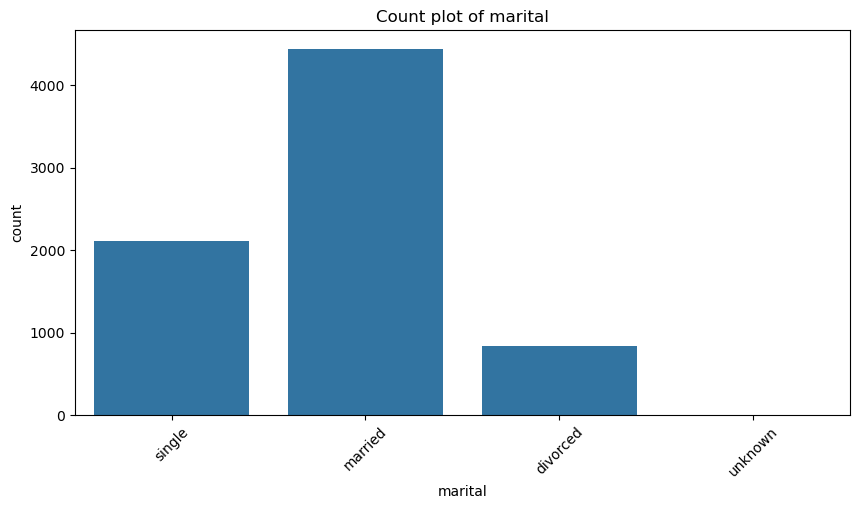

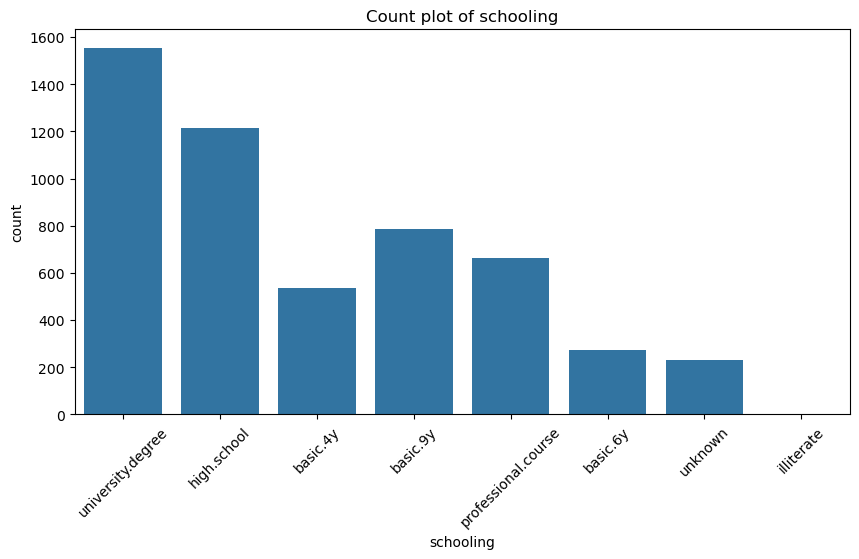

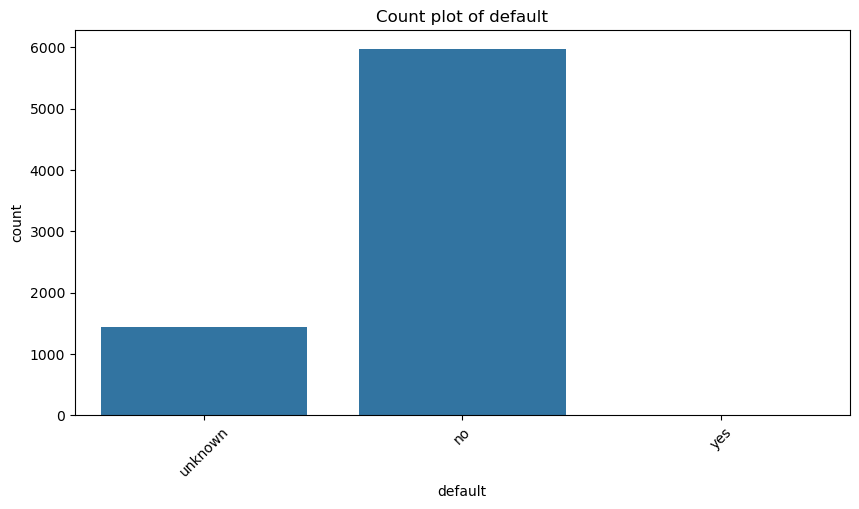

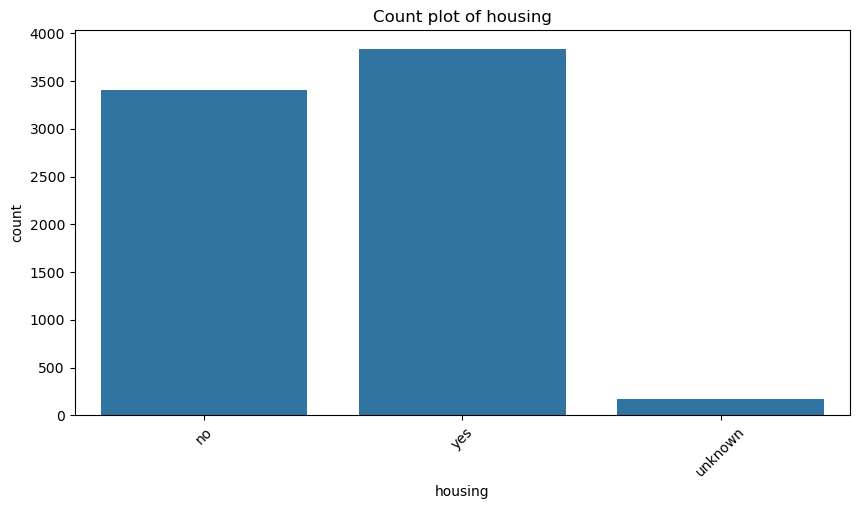

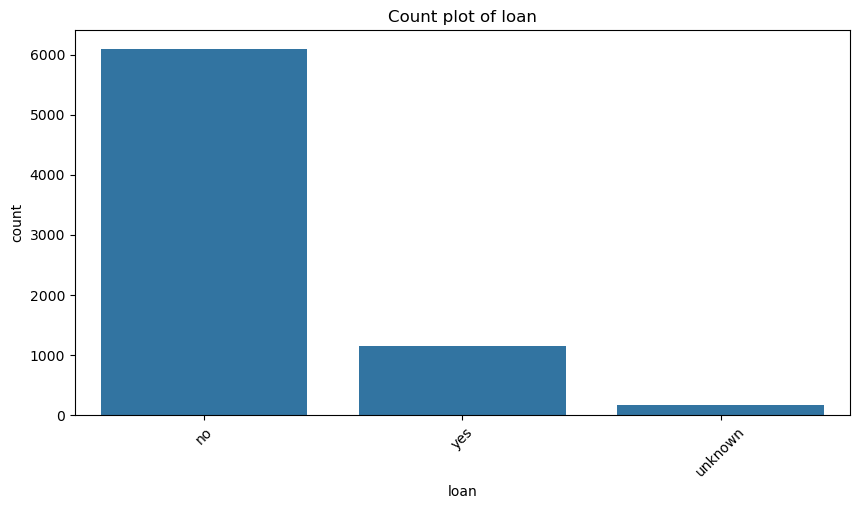

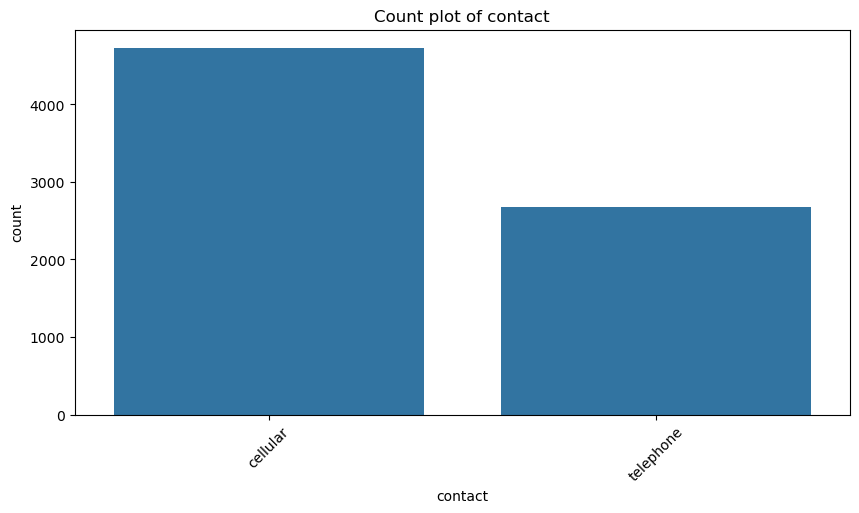

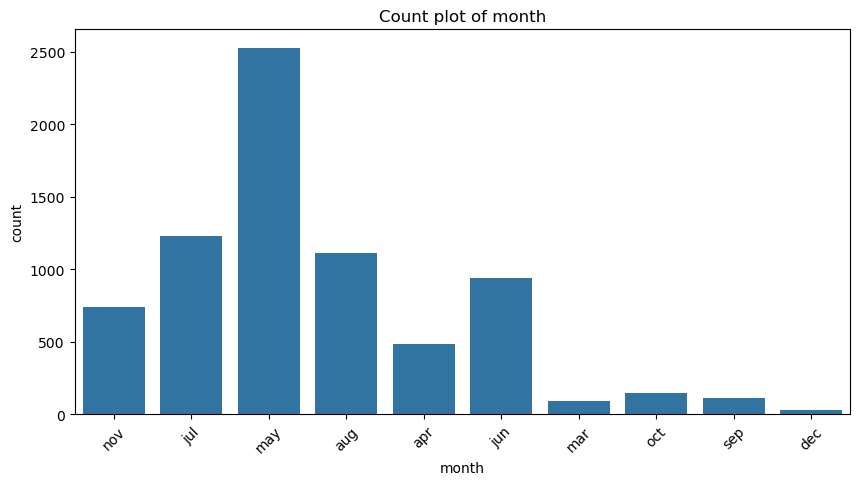

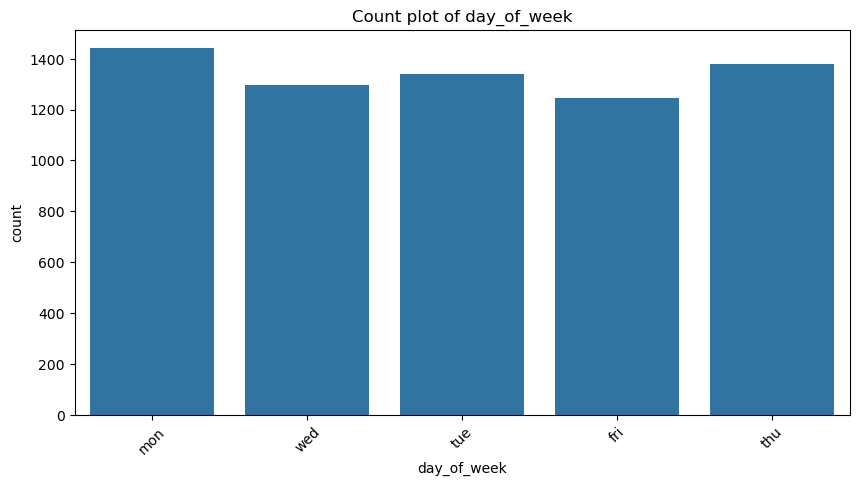

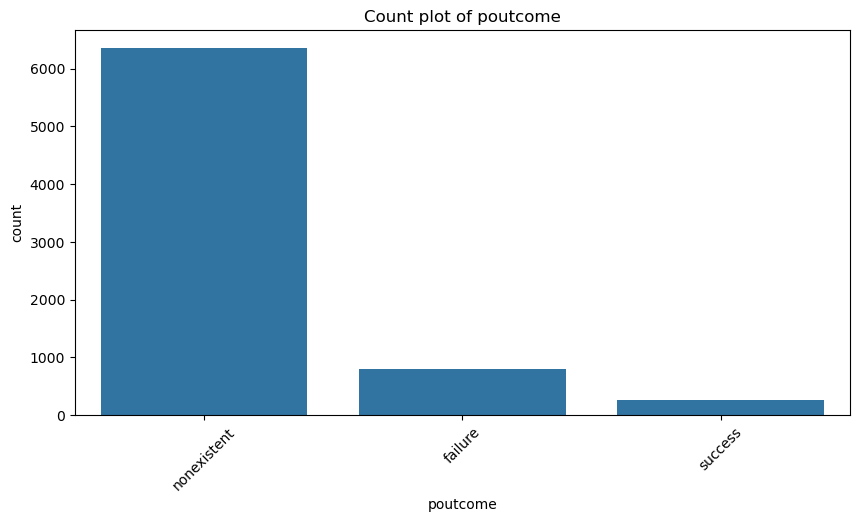

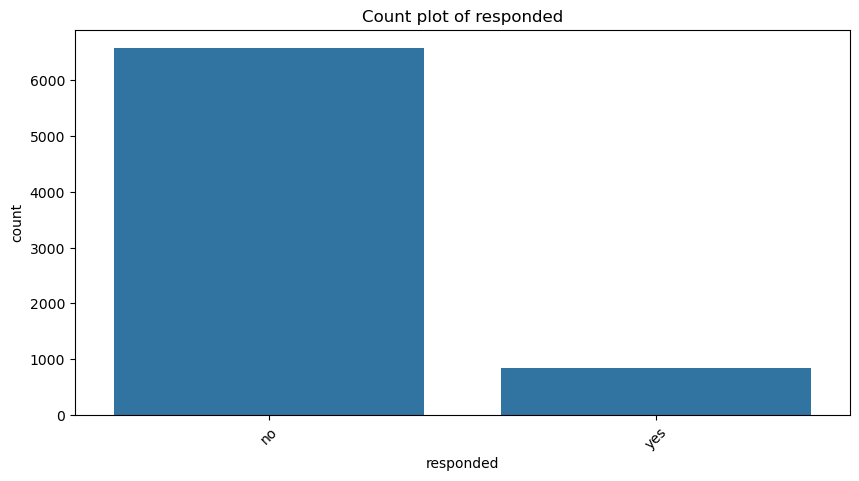

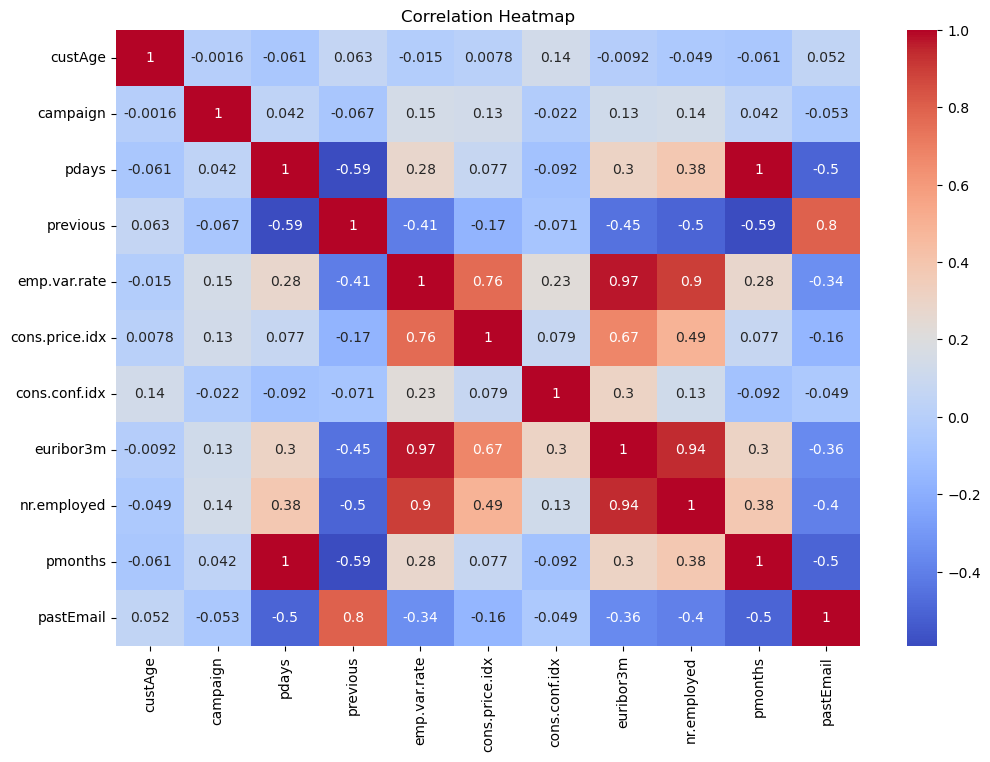

In [118]:
# Distribution of Numerical Features
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Count Plots for Categorical Features
categorical_columns = train_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_data, x=column)
    plt.title(f'Count plot of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = train_data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [119]:
# Handle missing values for 'custAge' with median imputation
median_age_imputer = SimpleImputer(strategy='median')
train_data['custAge'] = median_age_imputer.fit_transform(train_data[['custAge']]).ravel()

# Convert 'schooling' and 'day_of_week' to string type if not already
train_data['schooling'] = train_data['schooling'].astype(str)
train_data['day_of_week'] = train_data['day_of_week'].astype(str)

# Handle missing values for 'schooling' and 'day_of_week' with mode imputation
mode_imputer = SimpleImputer(strategy='most_frequent')
train_data['schooling'] = mode_imputer.fit_transform(train_data[['schooling']]).ravel()
train_data['day_of_week'] = mode_imputer.fit_transform(train_data[['day_of_week']]).ravel()


In [120]:
# Define categorical features
categorical_features = ['profession', 'marital', 'schooling', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform categorical features
encoded_categorical = onehot_encoder.fit_transform(train_data[categorical_features])

# Create DataFrame with encoded features
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the original DataFrame
train_data = pd.concat([train_data.drop(columns=categorical_features), encoded_categorical_df], axis=1)

# Verify the changes
print(train_data.head())

   custAge  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0     55.0         1    999         0          -0.1          93.200   
1     38.0         1    999         0           1.4          93.918   
2     42.0         1    999         0           1.1          93.994   
3     55.0         2    999         0           1.4          93.918   
4     38.0         5    999         1          -1.8          92.893   

   cons.conf.idx  euribor3m  nr.employed  pmonths  ...  month_nov month_oct  \
0          -42.0      4.191       5195.8    999.0  ...        1.0       0.0   
1          -42.7      4.960       5228.1    999.0  ...        0.0       0.0   
2          -36.4      4.857       5191.0    999.0  ...        0.0       0.0   
3          -42.7      4.962       5228.1    999.0  ...        0.0       0.0   
4          -46.2      1.291       5099.1    999.0  ...        0.0       0.0   

   month_sep  day_of_week_mon  day_of_week_nan  day_of_week_thu  \
0        0.0              1.0  

In [121]:
# List of numerical columns
numerical_cols = ['custAge', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths']  # Add other numerical columns if needed

# Initialize scaler
scaler = StandardScaler()

# Apply scaling
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

# Verify the scaling
print(train_data[numerical_cols].head())

    custAge  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.675590 -0.563419  0.202121 -0.356294     -0.096978       -0.641025   
1 -0.164620 -0.563419  0.202121 -0.356294      0.859475        0.600533   
2  0.268371 -0.563419  0.202121 -0.356294      0.668184        0.731952   
3  1.675590 -0.192344  0.202121 -0.356294      0.859475        0.600533   
4 -0.164620  0.920881  0.202121  1.578915     -1.180959       -1.171886   

   cons.conf.idx  euribor3m  nr.employed   pmonths  
0      -0.309429   0.348394     0.418252  0.202123  
1      -0.459983   0.789146     0.860089  0.202123  
2       0.895006   0.730111     0.352591  0.202123  
3      -0.459983   0.790292     0.860089  0.202123  
4      -1.212754  -1.313738    -0.904526  0.202123  


In [122]:
# For simplicity, we'll use IQR for outlier detection on numerical columns

# Calculate IQR for numerical columns
Q1 = train_data[numerical_cols].quantile(0.25)
Q3 = train_data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
for col in numerical_cols:
    train_data[col] = np.where(train_data[col] < lower_bound[col], lower_bound[col], train_data[col])
    train_data[col] = np.where(train_data[col] > upper_bound[col], upper_bound[col], train_data[col])

# Verify the handling of outliers
print(train_data[numerical_cols].describe())


           custAge     campaign         pdays      previous  emp.var.rate  \
count  7414.000000  7414.000000  7.414000e+03  7.414000e+03  7.414000e+03   
mean     -0.026500    -0.101653  2.021213e-01 -3.562935e-01 -1.174015e-17   
std       0.915040     0.566206  1.262964e-14  1.787580e-14  1.000067e+00   
min      -2.221325    -0.563419  2.021213e-01 -3.562935e-01 -2.201176e+00   
25%      -0.597610    -0.563419  2.021213e-01 -3.562935e-01 -1.180959e+00   
50%      -0.164620    -0.192344  2.021213e-01 -3.562935e-01  6.681845e-01   
75%       0.484866     0.178731  2.021213e-01 -3.562935e-01  8.594752e-01   
max       2.108580     1.291955  2.021213e-01 -3.562935e-01  8.594752e-01   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed       pmonths  
count    7.414000e+03    7414.000000  7.414000e+03  7.414000e+03  7.414000e+03  
mean    -1.373358e-14      -0.000128  9.583797e-17 -1.508490e-15  2.021227e-01  
std      1.000067e+00       0.999693  1.000067e+00  1.000067e+0

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Define features and target
X = train_data.drop('responded', axis=1)  # Use 'responded' as target
y = train_data['responded']  # Use 'responded' as target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)


Training set size: (5931, 56)
Test set size: (1483, 56)
Accuracy: 0.8745785569790965
Classification Report:
               precision    recall  f1-score   support

          no       0.89      0.98      0.93      1283
         yes       0.59      0.23      0.33       200

    accuracy                           0.87      1483
   macro avg       0.74      0.60      0.63      1483
weighted avg       0.85      0.87      0.85      1483

ROC AUC Score: 0.7609333593141077


In [ ]:
"""
1)Describe your model and why did you choose this model over other types of models?
I used a Random Forest classifier because of its effectiveness in handling both numerical and categorical variables, 
its robustness to overfitting, and its capacity to model complex relationships between features. Random Forest works well on large datasets and provides 
a good balance between accuracy and computational efficiency.

2)Describe any other models you have tried and why do you think this model performs better? 
I experimented with Logistic Regression and Decision Trees. However, the Random Forest outperformed them in terms of accuracy and ROC AUC score. 
Logistic Regression, being a linear model, failed to capture the non-linear relationships present in the data, while Decision Trees were prone to 
overfitting. The Random Forest, being an ensemble of decision trees, helped reduce overfitting and provided better generalization.

3)How did you handle missing data? 
I handled missing data by imputation. For numerical columns, I imputed missing values using the mean or median depending on the distribution. 
For categorical columns, I imputed missing values with an "unknown" category to ensure the model could still process them without discarding any data.

4)How did you handle categorical (string) data? 
I transformed categorical data using one-hot encoding, converting each category into binary features. This approach allowed the model to process 
categorical variables as numeric inputs, which is required by the Random Forest algorithm.

5)How did you handle unbalanced data? 
The dataset was unbalanced, particularly for the target class. I addressed this by using SMOTE (Synthetic Minority Over-sampling Technique) to 
oversample the minority class. Additionally, I adjusted the class weights in the Random Forest model to give more importance to the minority class, 
ensuring the model doesn't favor the majority class too heavily.

6)How did you test your model? 
I split the data into an 80-20 train-test split. The model was trained on the training set and tested on the holdout test set. I evaluated the 
performance using accuracy, precision, recall, F1-score, and the ROC AUC score. The model achieved an accuracy of 87.46%, with a weighted average 
precision and recall score showing strong performance, although precision and recall for the minority class ("yes") were lower due to class imbalance.
"""